In [176]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import einops as eo

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, Image, display

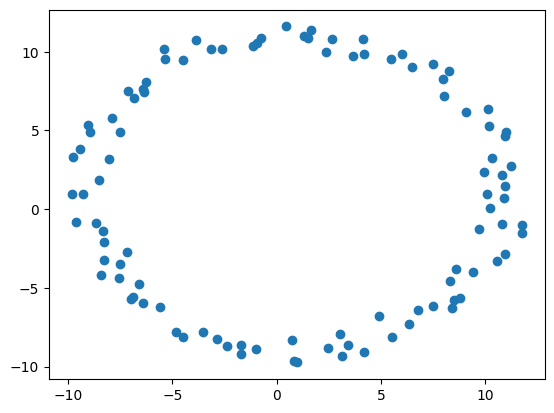

In [254]:
from tkinter import W


WORLD_DIM = 2
WORLD_WIDTH = 20

N_LANDMARKS = 100


def generate_landmarks(n_landmarks):
    angles = torch.linspace(0, 2 * torch.pi, n_landmarks)
    landmarks = torch.stack((torch.cos(angles), torch.sin(angles)), dim=-1) * (WORLD_WIDTH / 2)
    landmarks += torch.rand_like(landmarks) * WORLD_WIDTH * .1
    return landmarks

gt_landmarks = generate_landmarks(N_LANDMARKS)

plt.scatter(gt_landmarks[:, 0], gt_landmarks[:, 1])
plt.show()

In [255]:
N_FRAMES = 100

def generate_robot_states(n_states):
    AMAX = 0.01
    accelerations = torch.randn((n_states, WORLD_DIM)) * AMAX
    accelerations[accelerations.norm(dim=-1) < AMAX * 1.5] = 0
    
    velocities = torch.cumsum(accelerations, dim=0)
    positions = torch.cumsum(velocities, dim=0)

    AAMAX = 0.005
    angular_accelerations = torch.randn((n_states, 1)) * AAMAX
    angular_accelerations[angular_accelerations.norm(dim=-1) < AAMAX * 1.5] = 0

    angular_velocities = torch.cumsum(angular_accelerations, dim=0)
    thetas = torch.cumsum(angular_velocities, dim=0)
    directions = torch.cat([
        torch.cos(thetas), torch.sin(thetas)
    ], dim=-1)
    
    return dict(
        accelerations=accelerations,
        velocities=velocities,
        positions=positions,
        angular_accelerations=angular_accelerations,
        angular_velocities=angular_velocities,
        thetas=thetas,
        directions=directions,
    )

def world_to_robot(gt_landmarks: torch.Tensor, robot_states: dict):
    gt_landmarks = gt_landmarks.unsqueeze(1).expand(-1, N_FRAMES, -1)
    gt_landmarks = gt_landmarks - robot_states["positions"]

    forward_direction = robot_states["directions"]
    left_direction = torch.stack([
        forward_direction[:, 1], -forward_direction[:, 0]
    ], dim=-1)
    
    forward_positions = eo.einsum(
        gt_landmarks, forward_direction, "l t d, t d -> l t"
    )
    left_positions = eo.einsum(
        gt_landmarks, left_direction, "l t d, t d -> l t"
    )

    gt_landmark_observations = torch.stack([
        forward_positions, left_positions
    ], dim=-1)

    return gt_landmark_observations

In [ ]:
def vis_robot_states(robot_states: dict):
    QUIVER_INTERVAL = 5
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    ax = axs[0]
    ax.scatter(gt_landmarks[:, 0], gt_landmarks[:, 1], s=5)
    ax.plot(robot_states["positions"][:, 0], robot_states["positions"][:, 1], color='orange')

    ax.quiver(
        robot_states["positions"][::QUIVER_INTERVAL, 0],
        robot_states["positions"][::QUIVER_INTERVAL, 1],
        robot_states["directions"][::QUIVER_INTERVAL, 0],
        robot_states["directions"][::QUIVER_INTERVAL, 1],
        color='red',
        scale = 20,
        headwidth = 2,
    )
    ax.set_title("World")

    ax = axs[1]
    ax.plot(robot_states["accelerations"][:, 0], color='red')
    ax.plot(robot_states["accelerations"][:, 1], color='blue')
    ax.set_title("$a(t)$")

    ax = axs[2]
    ax.plot(robot_states["velocities"][:, 0], color='red')
    ax.plot(robot_states["velocities"][:, 1], color='blue')
    ax.set_title("$v(t)$")

    ax = axs[3]
    ax.plot(robot_states["positions"][:, 0], color='red')
    ax.plot(robot_states["positions"][:, 1], color='blue')
    ax.set_title("$p(t)$")

    plt.show()

def vis_landmark_observations(landmark_observations: torch.Tensor):
    FRAME_INTERVAL = 1

    fig, ax = plt.subplots(figsize=(5, 5))
    def update(frame):
        ax.clear()
        ax.scatter(landmark_observations[:, frame, 1], landmark_observations[:, frame, 0], s=5)
        ax.set_title(f"Frame {frame}")
        ax.axis('off')
        ax.set_xlim(-WORLD_WIDTH * .4, WORLD_WIDTH * .4)
        ax.set_ylim(0, WORLD_WIDTH * .8)

    ani = animation.FuncAnimation(fig, update, frames=range(0, N_FRAMES, FRAME_INTERVAL), interval=200)
    ani.save('landmark_observations.gif', writer='pillow')

    plt.close(fig)  # Prevent display of static plot
    display(Image(filename='landmark_observations.gif'))
    # HTML(ani.to_jshtml())

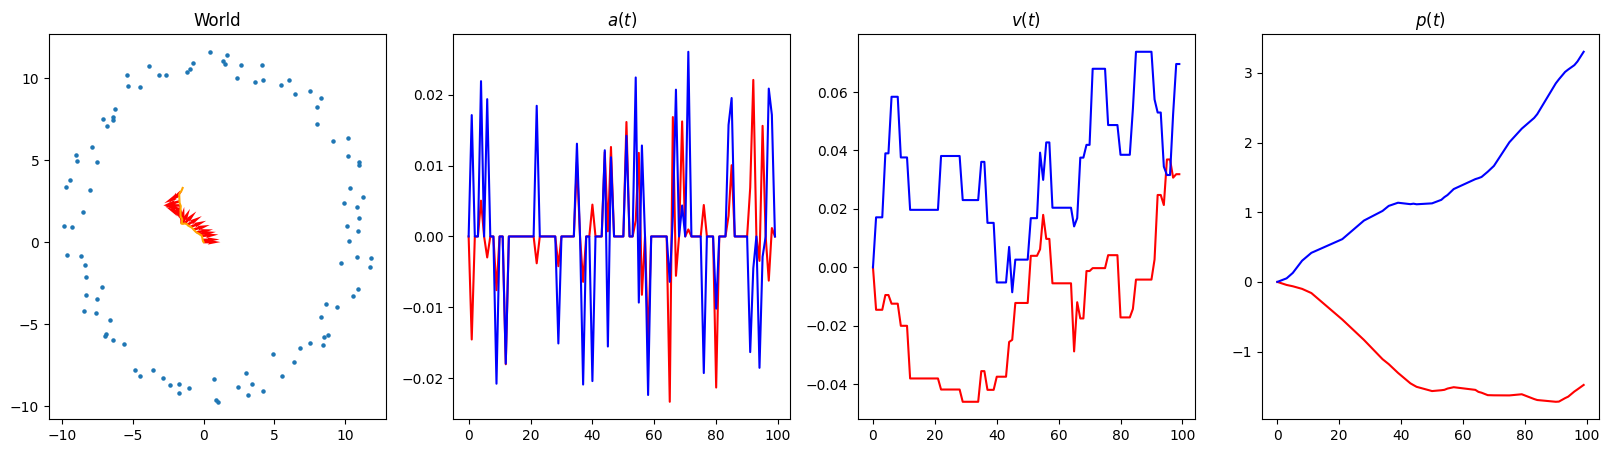

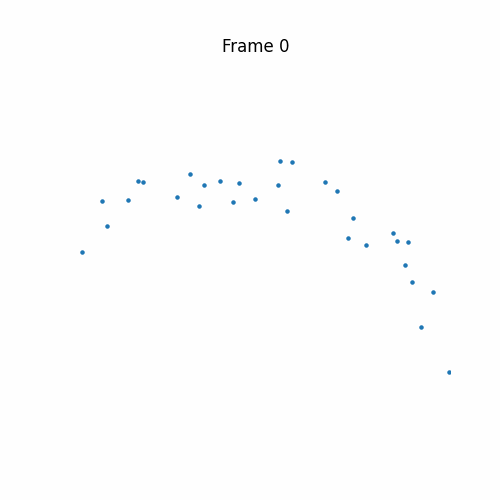

In [259]:



gt_robot_states = generate_robot_states(N_FRAMES)
landmark_observations = world_to_robot(gt_landmarks, gt_robot_states)

vis_robot_states(gt_robot_states)
vis_landmark_observations(landmark_observations)


